# Imports

In [1]:
# Python standard library
import sys
import csv
import os

# Scientific computing

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage
import sklearn.mixture

#plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', 'repo')
sys.path.append(PORE_STATS_BASE_DIRECTORY)


import optical_imaging as oi
import oi_file
import image_processing

In [2]:
PORE_STATS_BASE_DIRECTORY

'C:\\Users\\codyt\\Documents\\cell_code\\updated_code\\pore_stats\\repo\\oi'

# Load data

In [56]:
# Define file path
#data_base_path = oi_file.data_base_path
data_base_path = 'D:/'
date = '10-8-20'
particle_type = '/hl60d'
channel_type = '/25_50_25x150'
file_index = '1'


file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index+ '/bin/test_camera_0.raw'

#file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index+ '/bin/frames/frames.txt'


# Set output file path
oi_events_filepath= data_base_path + date + particle_type + channel_type + '/oi/' + file_index + '/events/test_camera_0' + '_events.json'

# Open video
res_x = 880
res_y = 140
fps = 11103
exp = 10
camera = 0

## camera = 0 is raw 16bpp chronos
oi_vid = oi_file.Video(file_path, res_x, res_y, fps, exp,camera=camera)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_filepath)

print 'loaded', len(oi_events), 'oi events'

loaded 280 oi events


##### Load ellipses

In [57]:
#oi_ellipse_base_path = oi_file.ellipse_base_path
oi_ellipse_base_path = 'D:/analysis/'
oi_ellipse_path = oi_ellipse_base_path + date + '/' + particle_type + '/' + channel_type + '/' + file_index + '/ellipses.txt'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

# Load template and create stage

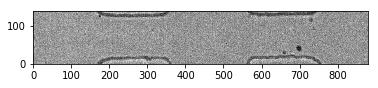

In [58]:
template_index = 102

template_frame = oi_vid.get_frame(template_index,camera= camera )

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

D:/10-8-20/hl60d/25_50_25x150/oi/1/stage/stage_0.txt
[[180, 125], [180, 20], [730, 20], [730, 125]]
[-0.  1.]


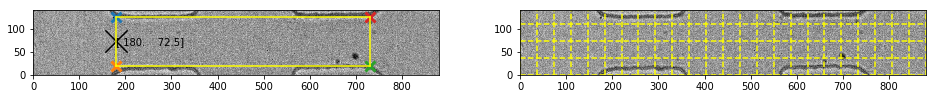

In [59]:
reload(oi)
template_frame = oi_vid.get_frame(template_index,camera=camera)
 
stage_file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index + '/stage/stage_0.txt' 
print stage_file_path
cs = oi.load_stage_file(stage_file_path)
print cs
c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage._length_microns = 150
oi_stage.plot_stage()

# Begin filtering

In [60]:
filtering_steps = {}

### Channel enter exit based filtering

In [61]:
keep_indices_enter_exit = []

for i, oi_event in enumerate(oi_events):
    try:
        xs = []
        ys = []

        for j, ellipse in enumerate(ellipsess[i]):
            xs.append(ellipse[1])
            ys.append(ellipse[2])

        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs,camera=camera)
        ycs = oi_stage.pixels_to_meters(ycs,camera=camera)

        if xcs.min() < 0 and xcs.max() > oi_stage._length_microns:
            keep_indices_enter_exit.append(i)
            
    except:
        # Catch-all: Do not append this element to the keep_indices_enter_exit list;
        #            This will prevent it from being analyzed.
        print 'failed on', i
        pass

In [62]:
filtering_steps['channel enter exit'] = [True]

print 'length before', len(oi_events), 'length after', len(keep_indices_enter_exit)
print
print 'events filtered by entrance/exit', [i for i in range(len(ellipsess)) if i not in keep_indices_enter_exit]

length before 280 length after 235

events filtered by entrance/exit [5, 9, 11, 21, 26, 27, 32, 35, 48, 80, 81, 90, 93, 109, 112, 114, 122, 131, 136, 142, 145, 146, 150, 167, 170, 180, 183, 186, 188, 189, 197, 202, 206, 208, 211, 212, 215, 220, 233, 244, 246, 251, 253, 263, 279]


## Geometry based filtering

radius failed on  8
aspect failed on  8
radius failed on  56
aspect failed on  56
radius failed on  63
aspect failed on  63
aspect failed on  113
radius failed on  115
aspect failed on  115
radius failed on  155
aspect failed on  155
radius failed on  156
aspect failed on  156
aspect failed on  157
radius failed on  182
aspect failed on  182
radius failed on  191
aspect failed on  191
radius failed on  227
aspect failed on  227


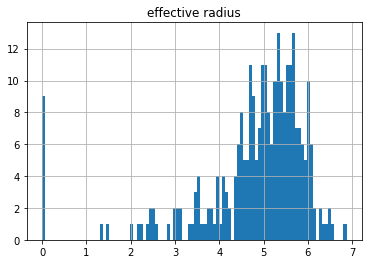

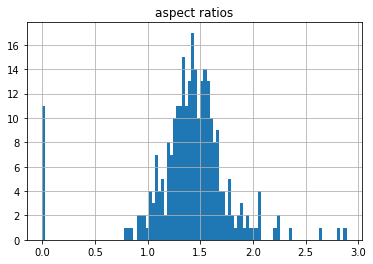

In [63]:
# Define left and right bounds that particle must be between for fitting its radius and aspect
#xc_left = 60
#xc_right = 90
xc_left = 20
xc_right = 40
yc_top = 100
yc_bottom = -100



effective_radii = []
effective_radius_max = 300

aspect_ratios = []
aspect_ratio_max = 3



for i, oi_event in enumerate(oi_events):
  
    aspect_ratio = 0
    effective_radius = 0
    for j, ellipse in enumerate(ellipsess[i]):
        
        x = ellipse[1]
        y = ellipse[2]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        xc = oi_stage.pixels_to_meters(xc,camera=camera)
        yc = oi_stage.pixels_to_meters(yc,camera=camera)
        
        
        
        
        if xc > xc_left and xc < xc_right and yc > yc_bottom and yc < yc_top:
            
            a = oi_stage.pixels_to_meters(ellipse[3],camera=camera)
            b = oi_stage.pixels_to_meters(ellipse[4],camera=camera)
            
           

            
            aspect_ratio = a/b

            effective_radius = np.sqrt(a*b)
        
            break
            
            
    # Catch bad values
    if effective_radius > effective_radius_max or np.isnan(effective_radius) or np.isinf(effective_radius):
        print 'radius failed on ', i
        effective_radius = 0
    
    
    
    if np.isnan(aspect_ratio) or np.isinf(aspect_ratio) or aspect_ratio > aspect_ratio_max:
        print 'aspect failed on ', i
        aspect_ratio = 0
    
    
        
    # Append values to lists        
    effective_radii.append(effective_radius)
    aspect_ratios.append(aspect_ratio)
    
            
plt.close()
plt.hist(effective_radii, bins = 100)
plt.title('effective radius')
plt.grid()
plt.show()
            
plt.hist(aspect_ratios, bins = 100)
plt.title('aspect ratios')
plt.grid()
plt.show()      

## Filter size

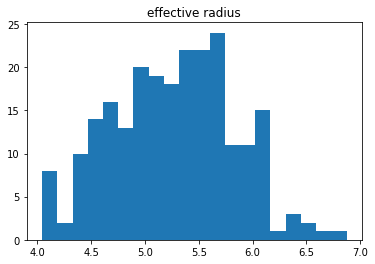

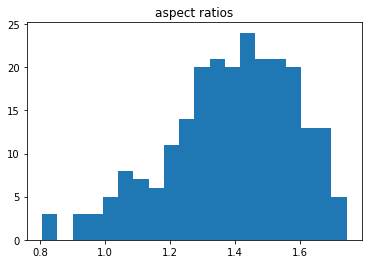

radius filtering 47/280

retained events (by radius)
[111, 82, 141, 149, 18, 51, 33, 22, 142, 44, 250, 163, 20, 34, 234, 86, 175, 235, 244, 84, 144, 58, 210, 14, 104, 39, 196, 134, 205, 245, 148, 132, 81, 25, 76, 3, 236, 69, 200, 11, 274, 221, 54, 41, 94, 171, 87, 64, 126, 198, 201, 135, 106, 36, 118, 74, 190, 68, 153, 273, 177, 224, 99, 215, 161, 186, 272, 4, 258, 100, 89, 247, 29, 30, 105, 50, 1, 269, 185, 233, 192, 93, 166, 112, 91, 152, 57, 194, 223, 188, 139, 47, 10, 216, 61, 65, 114, 208, 96, 23, 241, 251, 127, 275, 67, 218, 72, 214, 173, 140, 78, 70, 120, 160, 35, 184, 265, 117, 73, 143, 119, 121, 136, 109, 279, 183, 146, 90, 213, 179, 229, 6, 278, 5, 28, 252, 211, 193, 55, 195, 26, 103, 181, 77, 169, 12, 168, 187, 232, 231, 262, 264, 92, 237, 206, 248, 101, 260, 75, 98, 151, 266, 207, 60, 131, 27, 17, 19, 43, 48, 230, 222, 2, 197, 83, 154, 45, 162, 225, 259, 24, 178, 164, 176, 145, 255, 172, 202, 95, 42, 159, 122, 133, 267, 137, 268, 38, 246, 16, 129, 130, 125, 257, 13, 212, 26

In [64]:
# Filter size
radius_min = 4
radius_max = 10

filtering_steps['effective radius'] = [radius_min, radius_max]

keep_indices_radius = [i for i in range(len(effective_radii)) if ((effective_radii[i] > radius_min) and (effective_radii[i] < radius_max))]


# Filter aspect

aspect_min = 0.5
aspect_max = 1.75

filtering_steps['aspect ratio'] = [aspect_min, aspect_max]

keep_indices_aspect = [i for i in range(len(aspect_ratios)) if ((aspect_ratios[i] > aspect_min) and (aspect_ratios[i] < aspect_max))]



# Histograms
plt.hist(np.array(effective_radii)[keep_indices_radius], bins = 20)
plt.title('effective radius')
plt.show()
            
plt.hist(np.array(aspect_ratios)[keep_indices_aspect], bins = 20)
plt.title('aspect ratios')
plt.show()  




# Print

print ('radius filtering ' + str(len(oi_events) - len(keep_indices_radius)) + '/' + str(len(oi_events)))

print

print 'retained events (by radius)\n', [ele for ele in np.argsort(effective_radii) if ele in keep_indices_radius]

print 

print ('aspect ratio filtering ' + str(len(oi_events) - len(keep_indices_aspect)) + '/' + str(len(oi_events)))

print

print 'retained events (by aspect)\n', [ele for ele in np.argsort(aspect_ratios) if ele in keep_indices_aspect]

print

print('events filtered out by size but kept by aspect:')
print([i for i in range(len(oi_events)) if (i in keep_indices_aspect) and (i not in keep_indices_radius)])

print


print('events filtered out by aspect but kept by size:')
print([i for i in range(len(oi_events)) if (i not in keep_indices_aspect) and (i in keep_indices_radius)])

print


    


In [29]:
oi_indices = [251]
for oi_index in oi_indices:
    print oi_index

    print 'radius:', effective_radii[oi_index]
    print 'aspect:', aspect_ratios[oi_index]

    oi_event = oi_events[oi_index]
    ts = oi_event.get_tf()
    t = int((ts[-1] + ts[0])/2.)
    detection_index = t - ts[0]
    detection = oi_event._detections[detection_index]
    x = detection._px
    y = detection._py
    frame = oi_vid.get_frame(t,camera=camera)
    plt.scatter(x, y, marker = 'x', s = 100, color = 'red', lw = 0.5)

    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    plt.show()

251
radius:

IndexError: list index out of range

### y-based filtering

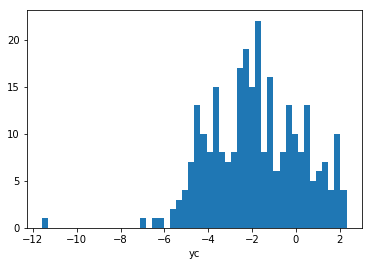

In [65]:
# Central cavity y-based filtering

yc_middles = []
yc_failed_indices = []

# Set yc_middle_min and max... These are bounds that we do not accept events outside of. Usually if there is
# a really bad fit, the detected yc value could be something like -60. This is unphysical, so we 
# manually introduce yc_middle_min and yc_middle_max to filter out unphysical values.
yc_middle_min = -25
yc_middle_max = 25

for i, oi_event in enumerate(oi_events):
    
    try:
        # Calculation sometimes fails, put in a 'try' block
        
        # Get positions of ellipses and convert to channel micron units
        xs = [ellipse[1] for ellipse in ellipsess[i]]
        ys = [ellipse[2] for ellipse in ellipsess[i]]
    
        
        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs,camera=camera)
        ycs = oi_stage.pixels_to_meters(ycs,camera = camera)
        

        # Interpolate the indices of x-positions
        #is_interp = scipy.interpolate.interp1d(xcs, range(len(xcs)))
    
    
        # Get the index closest to the middle of the channel
        #i_middle = int(is_interp(oi_stage._length_microns/2.))
        yc_middle = np.nanmean(ycs[(xcs > 10) & (xcs < 40)])
        
            
        #yc_middle = ycs[i_middle]
        
        
        if yc_middle > yc_middle_max or yc_middle < yc_middle_min or np.isnan(yc_middle):
            # The determined yc_middle is outside the manual bounds we set above; raise a ValueError
            # to exit try statement and go to except.
            print 'value error'
            raise ValueError
            
        yc_middles.append(yc_middle)

    
        
    except:
        # Calculation failed, add the index to the yc_failed_indices which will automatically be rejected
        # later on.
        print 'failed', i
        yc_failed_indices.append(i)
        yc_middles.append(-500)
    



    
# Apply offset to y so centered at 0... only count the successes
#yc_middles = np.array(yc_middles)
#yc_success_indices = np.array([i for i in range(len(oi_events)) if i not in yc_failed_indices])
#offset = -(np.max(yc_middles[yc_success_indices]) - np.abs(np.min(yc_middles[yc_success_indices])))/2.
#yc_middles = np.array(yc_middles)
#yc_middles = yc_middles + offset

yc_middles = np.array(yc_middles)

# Plot hist of all ys
plt.close()
#plt.hist(yc_middles[yc_success_indices], bins = 50)
plt.hist(yc_middles[(yc_middles >= yc_middle_min) & (yc_middles <= yc_middle_max)], bins = 50)
plt.xlabel('yc')
plt.show()



In [66]:
yc_threshold = 3
filtering_steps['yc cavity threshold'] = [yc_threshold]

keep_indices_y = np.where(np.abs(yc_middles) <= yc_threshold)[0]
keep_indices_y = [keep_index_y for keep_index_y in keep_indices_y if keep_index_y not in yc_failed_indices]

print 'length before', len(oi_events), 'length after', len(keep_indices_y)
print
print 'events retained (by y)', [ele for ele in np.argsort(yc_middles) if ele in keep_indices_y]

length before 280 length after 199

events retained (by y) [99, 138, 30, 195, 22, 55, 261, 222, 164, 226, 270, 89, 66, 276, 49, 256, 275, 102, 8, 25, 67, 45, 159, 63, 176, 83, 207, 273, 117, 16, 104, 240, 64, 268, 98, 168, 19, 179, 73, 123, 232, 219, 209, 177, 201, 62, 235, 20, 92, 78, 130, 243, 119, 70, 252, 15, 126, 181, 95, 224, 88, 192, 152, 185, 265, 228, 277, 193, 77, 274, 37, 127, 51, 86, 107, 175, 42, 60, 230, 53, 248, 56, 271, 214, 3, 198, 213, 156, 225, 266, 74, 140, 111, 17, 0, 38, 223, 10, 239, 125, 165, 229, 34, 105, 272, 4, 14, 57, 75, 31, 178, 91, 158, 203, 28, 50, 137, 262, 169, 218, 2, 7, 205, 236, 18, 153, 166, 68, 237, 234, 157, 269, 149, 96, 151, 200, 245, 135, 129, 94, 72, 52, 255, 44, 171, 249, 259, 71, 41, 1, 264, 58, 24, 132, 121, 247, 257, 204, 194, 103, 278, 241, 147, 54, 39, 33, 59, 120, 187, 46, 184, 69, 238, 84, 217, 190, 118, 154, 76, 134, 260, 148, 47, 87, 133, 210, 116, 160, 13, 61, 29, 143, 231, 216, 254, 40, 12, 106, 65]


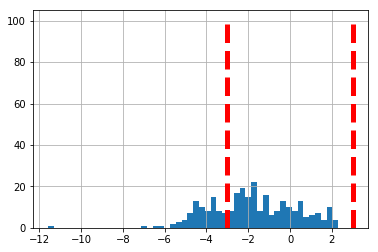

In [67]:
plt.hist(yc_middles[(yc_middles >= yc_middle_min) & (yc_middles <= yc_middle_max)], bins = 50)
plt.plot([-yc_threshold, -yc_threshold], [0,100], ls = '--', c = 'r', lw = 5)
plt.plot([yc_threshold, yc_threshold], [0,100], ls = '--', c = 'r', lw = 5)
plt.grid()
plt.show()

## Manual filtering
- Inspect the events that haven't been filtered out yet to make sure they are good.
- Add undesirable events to the 'manual_remove_indices' list

In [68]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_enter_exit)\
                                                     and (i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y))]

print 'keeping', len(keep_indices), '/', len(ellipsess), 'events before manual removal'
print 'events to be kept:', keep_indices

keeping 157 / 280 events before manual removal
events to be kept: [0, 1, 2, 3, 4, 10, 14, 16, 17, 18, 19, 20, 22, 24, 28, 29, 30, 33, 34, 37, 38, 39, 41, 42, 44, 45, 51, 54, 55, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 84, 86, 89, 91, 92, 94, 95, 96, 98, 99, 103, 104, 105, 106, 111, 117, 118, 119, 120, 121, 123, 125, 126, 127, 129, 130, 133, 134, 135, 138, 140, 143, 148, 149, 151, 152, 153, 154, 158, 159, 160, 164, 166, 168, 169, 171, 175, 176, 177, 178, 179, 181, 184, 185, 187, 192, 193, 194, 195, 198, 200, 201, 203, 205, 207, 209, 210, 213, 214, 216, 218, 219, 222, 223, 224, 225, 229, 230, 231, 232, 234, 236, 237, 238, 240, 241, 243, 245, 247, 248, 252, 255, 256, 257, 260, 261, 262, 264, 265, 266, 269, 271, 272, 273, 274, 275, 276, 277, 278]


##### Inspect frame

4
radius: 7.64287025369
aspect: 1.0571058687


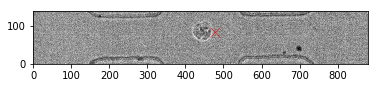

5
radius: 6.8100695865
aspect: 1.30699679576


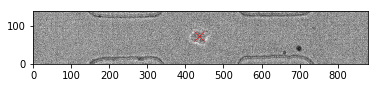

8
radius: 8.43140175319
aspect: 1.11538933345


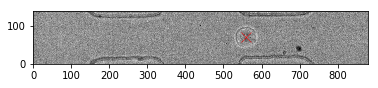

9
radius: 7.89913126343
aspect: 1.2226517621


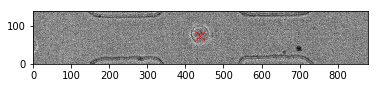

18
radius: 8.2779658151
aspect: 1.32513169366


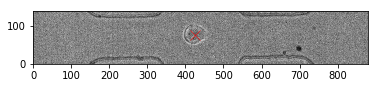

23
radius: 7.83899870394
aspect: 1.38075771318


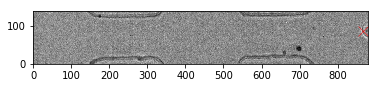

24
radius: 7.25272360173
aspect: 1.14039015559


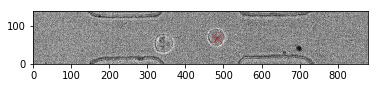

28
radius: 8.58113544505
aspect: 1.19935353745


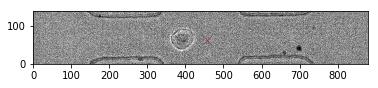

29
radius: 7.6956653299
aspect: 1.26145144925


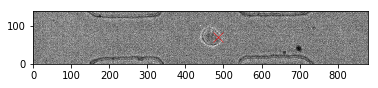

31
radius: 7.56323169029
aspect: 1.15582208565


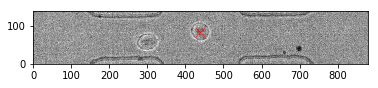

33
radius: 8.84924059601
aspect: 1.19427767369


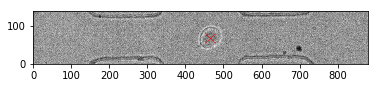

34
radius: 7.77928024054
aspect: 1.1484467136


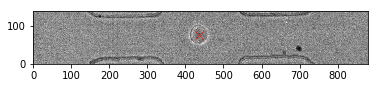

37
radius: 8.13666814408
aspect: 1.14152405529


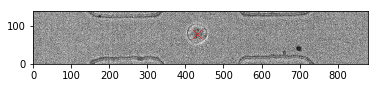

41
radius: 7.29489412174
aspect: 1.3248298505


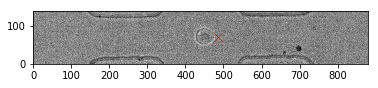

42
radius: 7.53854949243
aspect: 1.19591501873


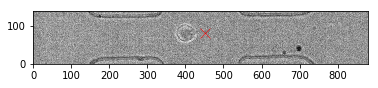

43
radius: 7.6733031055
aspect: 1.2684690627


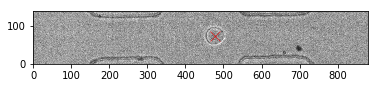

44
radius: 7.77077427094
aspect: 1.26061565201


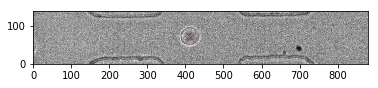

47
radius: 8.37827861225
aspect: 1.15305709434


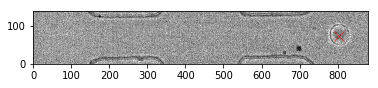

50
radius: 8.32289775203
aspect: 1.19701379283


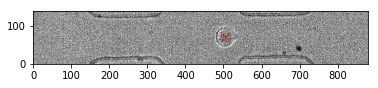

51
radius: 8.07798615165
aspect: 1.19716678011


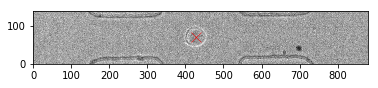

52
radius: 8.46775447487
aspect: 1.21302553149


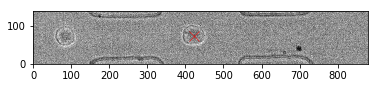

53
radius: 8.03987471795
aspect: 1.02938917037


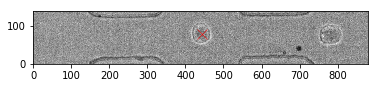

58
radius: 8.24925842954
aspect: 0.995753434884


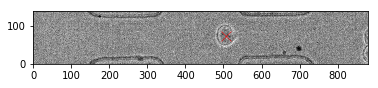

61
radius: 7.8457388554
aspect: 1.24260559537


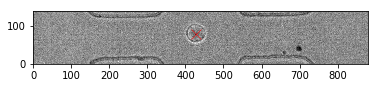

70
radius: 8.55681856363
aspect: 1.12295594907


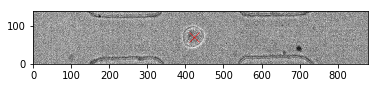

73
radius: 7.39845444598
aspect: 1.28469947935


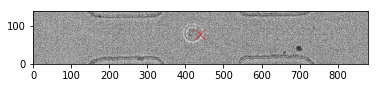

74
radius: 9.58203586719
aspect: 1.34995617831


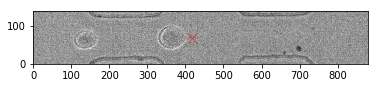

77
radius: 9.58685055821
aspect: 1.53174727402


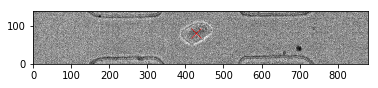

78
radius: 5.85768300393
aspect: 0.820901315371


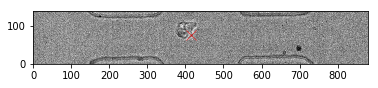

81
radius: 8.38388160074
aspect: 1.61055403343


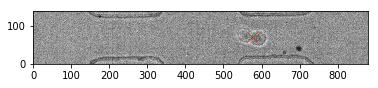

82
radius: 8.165404723
aspect: 1.15972250518


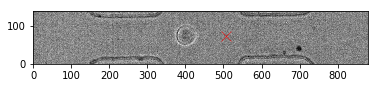

87
radius: 7.71960132278
aspect: 1.11667414071


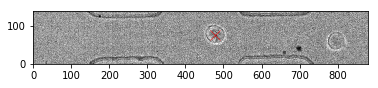

88
radius: 7.80626124274
aspect: 1.29667711224


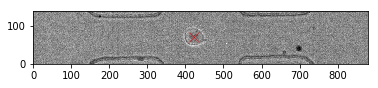

90
radius: 7.49415592153
aspect: 1.19945963428


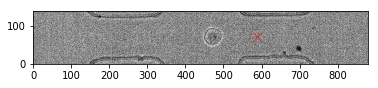

105
radius: 7.55591709244
aspect: 1.16834628485


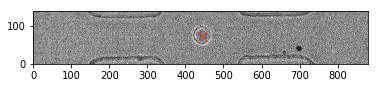

109
radius: 7.98346731899
aspect: 1.27191996829


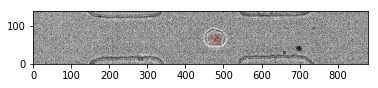

113
radius: 8.53456276753
aspect: 1.30014340401


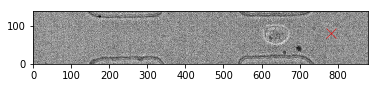

114
radius: 7.77619614413
aspect: 1.39039329787


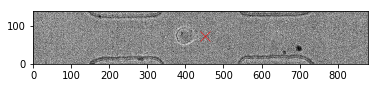

116
radius: 7.47527202425
aspect: 1.0928810553


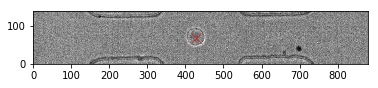

117
radius: 7.10142192292
aspect: 1.28039040957


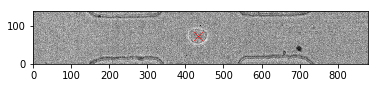

118
radius: 5.72687851171
aspect: 0.885165843865


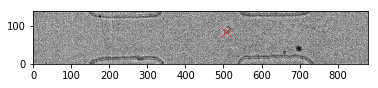

119
radius: 8.53219911658
aspect: 1.2333725243


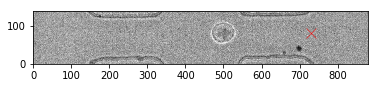

120
radius: 8.22717956948
aspect: 1.35897679387


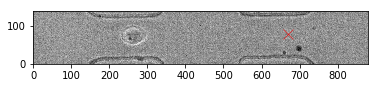

121
radius: 7.83025407015
aspect: 1.10739007344


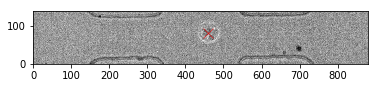

123
radius: 7.64838233664
aspect: 1.3117820797


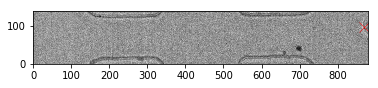

126
radius: 7.7543607514
aspect: 1.35268788964


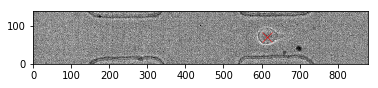

128
radius: 7.74279611251
aspect: 1.13945404244


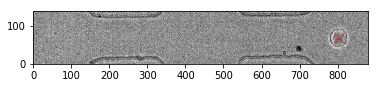

129
radius: 7.56300403082
aspect: 1.33478273176


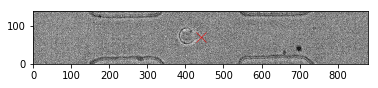

130
radius: 7.06748607628
aspect: 1.19171653252


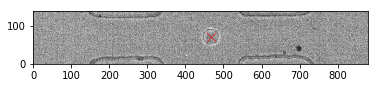

132
radius: 8.48286271833
aspect: 1.13532175731


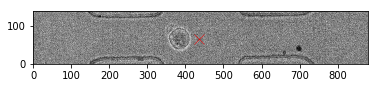

134
radius: 6.81587274633
aspect: 1.35343282472


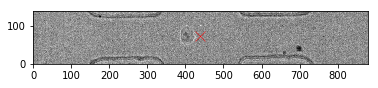

139
radius: 7.81828744742
aspect: 1.31962457054


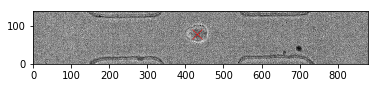

144
radius: 8.00402053153
aspect: 1.27683666973


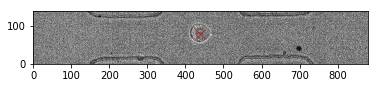

145
radius: 8.0267471486
aspect: 1.1405716401


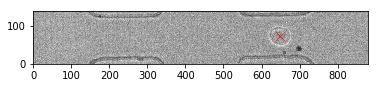

149
radius: 8.40138819249
aspect: 1.22414562702


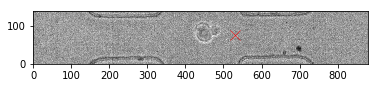

150
radius: 7.75900305516
aspect: 1.19403430925


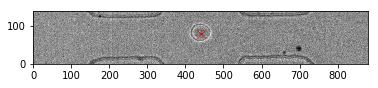

153
radius: 7.7036675111
aspect: 1.33559717857


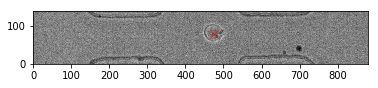

155
radius: 7.66373894834
aspect: 1.34686846472


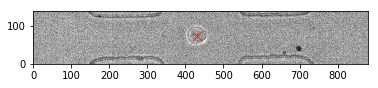

156
radius: 8.45793026593
aspect: 1.16778905062


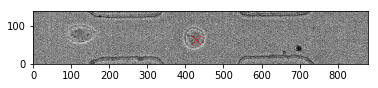

162
radius: 8.29764658002
aspect: 1.31311300684


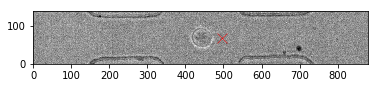

163
radius: 9.16420375143
aspect: 1.5222733418


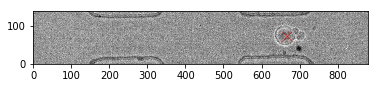

164
radius: 7.91542954083
aspect: 1.21756188686


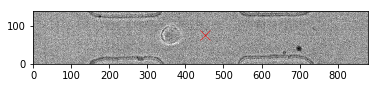

168
radius: 7.43509025919
aspect: 1.22021113861


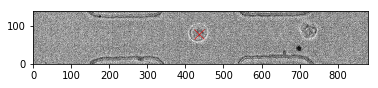

169
radius: 8.77349191124
aspect: 1.18559710054


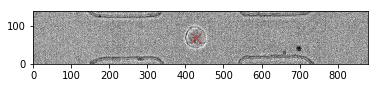

171
radius: 7.33158230989
aspect: 1.44872639919


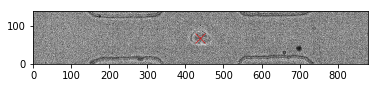

175
radius: 8.37777289453
aspect: 1.47020251438


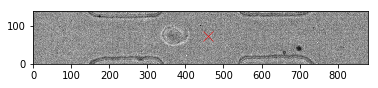

176
radius: 7.26229031411
aspect: 1.1962967535


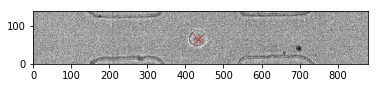

178
radius: 5.51566068455
aspect: 1.01918714484


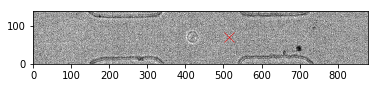

181
radius: 7.6896542502
aspect: 1.51952447082


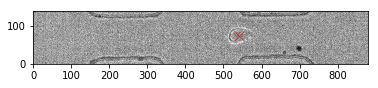

183
radius: 7.57856216414
aspect: 1.28232759448


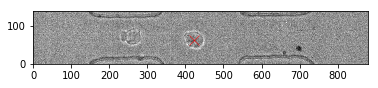

184
radius: 7.55390393027
aspect: 1.25725958115


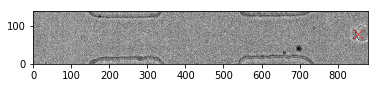

186
radius: 8.49401694385
aspect: 1.22296166571


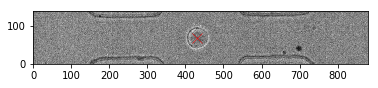

195
radius: 7.63833850649
aspect: 1.341130956


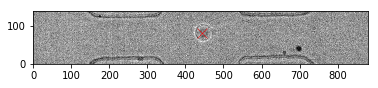

196
radius: 8.65413836184
aspect: 1.33199820567


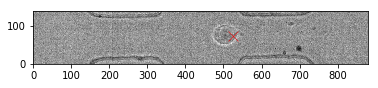

199
radius: 7.74985396673
aspect: 1.12478433739


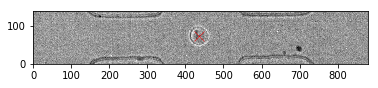

203
radius: 7.83512454016
aspect: 1.30085821647


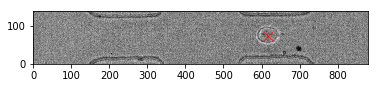

206
radius: 7.8519373561
aspect: 1.16793905888


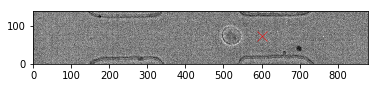

210
radius: 7.61029829671
aspect: 1.25734092931


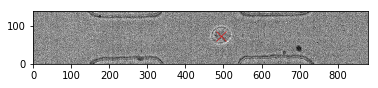

212
radius: 8.30515646039
aspect: 1.329022642


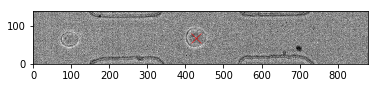

213
radius: 7.06475428072
aspect: 1.19316617311


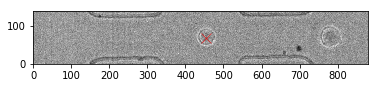

222
radius: 8.19378597061
aspect: 1.25695095091


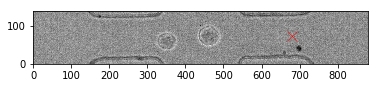

224
radius: 7.49493245578
aspect: 1.12937018081


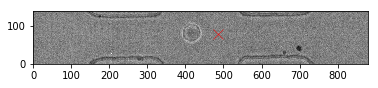

226
radius: 8.21600880067
aspect: 1.14708829401


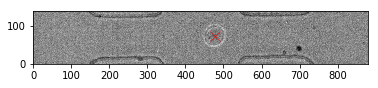

227
radius: 7.76133446173
aspect: 1.16561101152


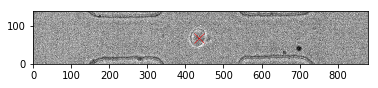

228
radius: 8.60435936992
aspect: 1.18572594944


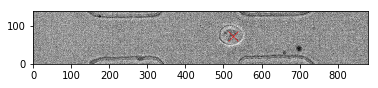

229
radius: 7.51813812389
aspect: 1.27539186689


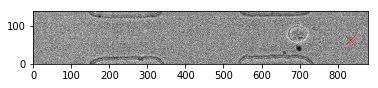

237
radius: 8.3349461578
aspect: 1.28856878461


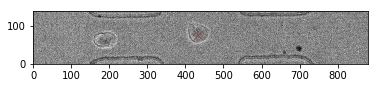

240
radius: 8.30551682751
aspect: 1.29729771116


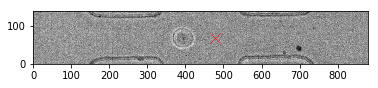

244
radius: 8.49683398411
aspect: 1.40785274964


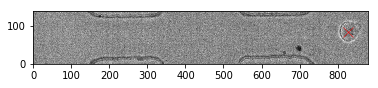

250
radius: 7.37876438795
aspect: 1.22617551025


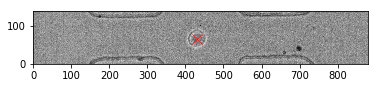

254
radius: 8.51161996039
aspect: 1.2549580822


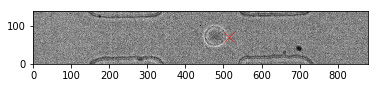

256
radius: 7.11835599192
aspect: 1.24706586415


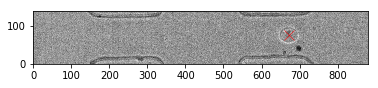

257
radius: 7.80098176452
aspect: 1.09804580403


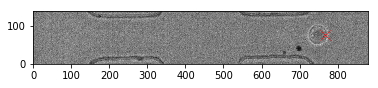

259
radius: 7.80574851664
aspect: 1.23245680827


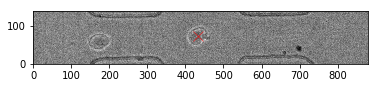

261
radius: 7.96920947478
aspect: 1.26487103763


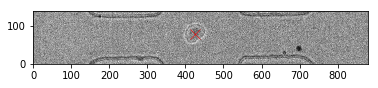

262
radius: 8.06144800163
aspect: 1.54798883879


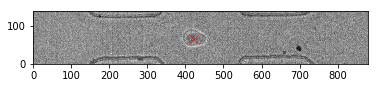

264
radius: 8.69115757879
aspect: 1.25499046509


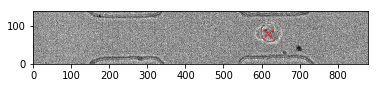

267
radius: 7.19890371707
aspect: 1.09357994148


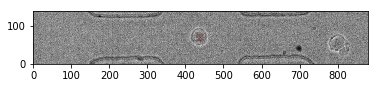

268
radius: 7.87131400486
aspect: 1.27550444577


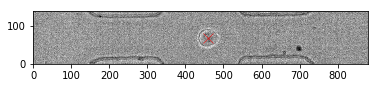

272
radius: 5.43759216568
aspect: 1.15107516831


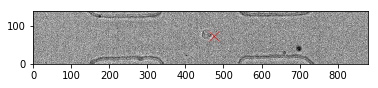

274
radius: 7.00691281457
aspect: 1.18462535913


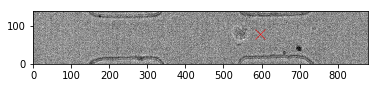

277
radius: 7.39082230892
aspect: 1.14437321328


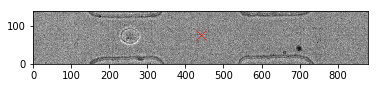

279
radius: 7.69939425062
aspect: 1.16347810164


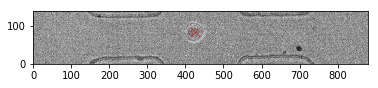

284
radius: 8.02078000636
aspect: 1.24242935746


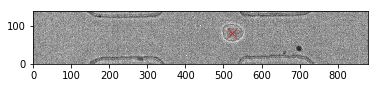

285
radius: 8.03008233568
aspect: 1.13076396185


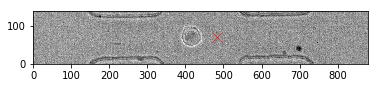

286
radius: 7.88646822027
aspect: 1.17152468727


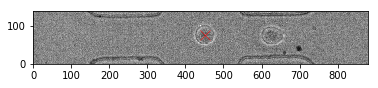

290
radius: 5.91609747897
aspect: 0.874806185327


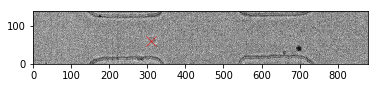

In [19]:
for oi_index in keep_indices:
    
    print oi_index

    print 'radius:', effective_radii[oi_index]
    print 'aspect:', aspect_ratios[oi_index]

    oi_event = oi_events[oi_index]
    ts = oi_event.get_tf()
    t = int((ts[-1] + ts[0])/2.)
    detection_index = t - ts[0]
    detection = oi_event._detections[detection_index]
    x = detection._px
    y = detection._py
    frame = oi_vid.get_frame(t,camera=camera)
    plt.scatter(x, y, marker = 'x', s = 100, color = 'red', lw = 0.5)

    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    plt.show()

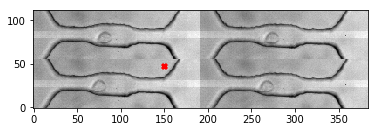

In [56]:
oi_index = 33
oi_event = oi_events[oi_index]
detection_index = int(len(oi_event._detections)/2.)
t = oi_event._detections[detection_index]._tf
frame = oi_vid.get_frame(t)



plt.close()
plt.imshow(frame, cmap = 'gray', origin = 'lower')
plt.scatter(oi_event._detections[detection_index]._px, oi_event._detections[detection_index]._py,\
            marker = 'x', c = 'red', lw = 3, s = 25)
plt.show()

In [69]:
manual_remove_indices = []

filtering_steps['manual removal'] = [len(manual_remove_indices)]

print 'manually removing indices', manual_remove_indices

keep_indices_manual = [i for i in range(len(oi_events)) if i not in manual_remove_indices]

manually removing indices []


## Filtering step

In [70]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_enter_exit)\
                                                     and (i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y)\
                                                    and (i in keep_indices_manual))]


print(keep_indices)
print
print
print('filtering ' + str(len(oi_events) - len(keep_indices)) + ' out of ' + str(len(oi_events)) + ' events')

[0, 1, 2, 3, 4, 10, 14, 16, 17, 18, 19, 20, 22, 24, 28, 29, 30, 33, 34, 37, 38, 39, 41, 42, 44, 45, 51, 54, 55, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 84, 86, 89, 91, 92, 94, 95, 96, 98, 99, 103, 104, 105, 106, 111, 117, 118, 119, 120, 121, 123, 125, 126, 127, 129, 130, 133, 134, 135, 138, 140, 143, 148, 149, 151, 152, 153, 154, 158, 159, 160, 164, 166, 168, 169, 171, 175, 176, 177, 178, 179, 181, 184, 185, 187, 192, 193, 194, 195, 198, 200, 201, 203, 205, 207, 209, 210, 213, 214, 216, 218, 219, 222, 223, 224, 225, 229, 230, 231, 232, 234, 236, 237, 238, 240, 241, 243, 245, 247, 248, 252, 255, 256, 257, 260, 261, 262, 264, 265, 266, 269, 271, 272, 273, 274, 275, 276, 277, 278]


filtering 123 out of 280 events


# Save
- Save the filtering parameters as well as the indices of the events to be kept

### Save filtering parameters and indices

In [71]:
#output_base_path = oi_file.ellipse_base_path
output_base_path = 'D:/analysis/'
output_file_path = output_base_path + date + '/' + particle_type + '/' + channel_type + '/' + file_index + '/filter'
print 'saving to ', output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    
    # Write filtering steps
    for filtering_step in filtering_steps:
        file_writer.writerow(['filter step', filtering_step, filtering_steps[filtering_step]])
        
    file_writer.writerow(['events'] + keep_indices)

saving to  D:/analysis/10-8-20//hl60d//25_50_25x150/1/filter
